## Building an Image Classifier from Scratch

## Using the Original Data

### Dataset Verification

In [2]:
import os.path
from os import path

In [3]:
path.exists('training_data')

True

In [4]:
path.exists('validation_data')

True

In [5]:
path.exists('testing_data')

True

### Dataset Loading and Processing with Image Data Generators

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

Creating variables for which the the paths to the train, valid, and test data folders are assigned.

In [7]:
train_path = 'training_data'
valid_path = 'validation_data'
test_path = 'testing_data'

Now, we use Keras' ImageDataGenerator class to create batches of data from the train, valid, and test directories.

In [8]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(148,148), classes=['female', 'male'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(148,148), classes=['female', 'male'], batch_size=5)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(148,148), classes=['female', 'male'], batch_size=5, shuffle=False)

Found 100 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


We now call next(train_batches) to generate a batch of images and labels from the training set. The size of this batch is determined by the batch_size we set when we created train_batches.

In [9]:
imgs, labels = next(train_batches)

We then use this plotting function obtained from TensorFlow's documentation to plot the processed images within our Jupyter notebook

In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

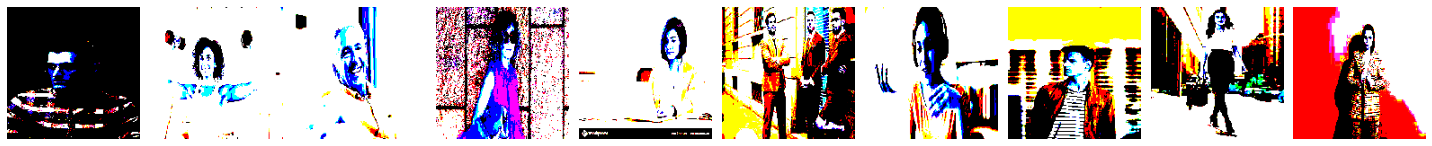

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [11]:
plotImages(imgs)
print(labels)

Here males are represented with the one-hot encoding of [0,1], and females are represented by [1,0]

### Create and Evaluate a Model

In [12]:
num_classes = 2
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(148, 148, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2)
])

The first layer in the model is a 2-dimensional convolutional layer. This layer will have 16 output filters each with a kernel size of 3x3, and we’ll use the relu activation function.On the first layer only, we also specify the input_shape, which is the shape of our data. Our images are 148 pixels high and 148 pixels wide and have 3 color channels: RGB. This gives us an input_shape of (148,148,3).We then add a max pooling layer to pool and reduce the dimensionality of the data.We follow this by adding another convolutional layer with the exact specs as the earlier one, except for this second Conv2D layer has 32 filters.This layer is again followed by the same type of MaxPool2D layer.Again a Conv2D of 64 filters and MaxPool2D is added.We then Flatten the output from the convolutional layer and pass it to a Dense layer. This Dense layer is the output layer of the network, and so it has 2 nodes, one for females and one for males. We used the relu activation function on our output.

Checking out the summary of the model by calling model.summary().

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 148, 148, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0

We compiled the model using the Adam optimizer with a learning rate of 0.0001, a loss of categorical_cross_entropy, and we took accuracy as our performance metric.

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit() function is used to train the model. We passed DirectoryIterators train_batches and valid_batches to train and validate the model. 

We need to specify steps_per_epoch to indicate how many batches of samples from our training set should be passed to the model before declaring one epoch complete. Since we have 100 samples in our training set, and our batch size is 10, then we set steps_per_epoch to be 10, since 10 batches of 10 samples each will encompass our entire training set.

We're able to use len(train_batches) as a more general way to specify this value, as the length of train_batches is equal to 100 since it is made up of 10 batches of 10 samples. Similarly, we specify validation_steps in the same fashion but with using valid_batches.

We’re specifying 10 as the number of epochs we’d like to run, and setting the verbose parameter to 2, which just specifies the verbosity of the log output printed to the console during training.

In [15]:
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    batch_size=1,
    epochs=10,
    verbose=2
)

Epoch 1/10
10/10 - 24s - loss: 1.3111 - accuracy: 0.5100 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/10
10/10 - 24s - loss: 0.6751 - accuracy: 0.6000 - val_loss: 0.6890 - val_accuracy: 0.5000
Epoch 3/10
10/10 - 23s - loss: 0.6551 - accuracy: 0.7100 - val_loss: 0.6858 - val_accuracy: 0.5000
Epoch 4/10
10/10 - 20s - loss: 0.6454 - accuracy: 0.6300 - val_loss: 0.6838 - val_accuracy: 0.5333
Epoch 5/10
10/10 - 25s - loss: 0.6063 - accuracy: 0.7200 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 6/10
10/10 - 23s - loss: 0.5502 - accuracy: 0.8100 - val_loss: 0.7164 - val_accuracy: 0.5667
Epoch 7/10
10/10 - 22s - loss: 0.3659 - accuracy: 0.8500 - val_loss: 2.4758 - val_accuracy: 0.6333
Epoch 8/10
10/10 - 21s - loss: 1.1535 - accuracy: 0.7600 - val_loss: 1.6873 - val_accuracy: 0.6000
Epoch 9/10
10/10 - 19s - loss: 0.3857 - accuracy: 0.8800 - val_loss: 1.6257 - val_accuracy: 0.6000
Epoch 10/10
10/10 - 21s - loss: 2.3101 - accuracy: 0.9200 - val_loss: 6.7233 - val_accuracy: 0.5000


### Report Accuracy on Test Set

In this code similar as the previous one, we have changed the validaition data to test_batches, inorder to report the accuracy on the test set.

In [16]:
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=test_batches,
    validation_steps=len(test_batches),
    batch_size=1,
    epochs=10,
    verbose=2
)

Epoch 1/10
10/10 - 32s - loss: 1.5965 - accuracy: 0.5300 - val_loss: 0.8384 - val_accuracy: 0.4667
Epoch 2/10
10/10 - 33s - loss: 0.5986 - accuracy: 0.6500 - val_loss: 0.7364 - val_accuracy: 0.4667
Epoch 3/10
10/10 - 32s - loss: 0.5866 - accuracy: 0.7300 - val_loss: 0.7281 - val_accuracy: 0.4667
Epoch 4/10
10/10 - 31s - loss: 0.5790 - accuracy: 0.7300 - val_loss: 0.7318 - val_accuracy: 0.4667
Epoch 5/10
10/10 - 35s - loss: 0.5680 - accuracy: 0.7300 - val_loss: 0.7371 - val_accuracy: 0.4667
Epoch 6/10
10/10 - 32s - loss: 0.5494 - accuracy: 0.7300 - val_loss: 0.7417 - val_accuracy: 0.4667
Epoch 7/10
10/10 - 32s - loss: 0.5286 - accuracy: 0.7300 - val_loss: 0.7550 - val_accuracy: 0.4667
Epoch 8/10
10/10 - 31s - loss: 0.5013 - accuracy: 0.7600 - val_loss: 0.7938 - val_accuracy: 0.4667
Epoch 9/10
10/10 - 31s - loss: 0.4632 - accuracy: 0.7600 - val_loss: 0.8363 - val_accuracy: 0.4667
Epoch 10/10
10/10 - 31s - loss: 0.4188 - accuracy: 0.7900 - val_loss: 1.4583 - val_accuracy: 0.4667


## Part 3: Using Data Augmentation

## Adding Data Augmentation

### Dataset Verification

In [17]:
path.exists('training_data')

True

In [18]:
path.exists('validation_data')

True

In [19]:
path.exists('testing_data')

True

### Dataset Loading and Processing with Create Image Data Generators

Creating variables for which the the paths to the train, valid, and test data folders are assigned.

In [20]:
train_path = 'training_data'
valid_path = 'validation_data'
test_path = 'testing_data'

Now, we use Keras' ImageDataGenerator class to create batches of data from the train, valid, and test directories.

In [21]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(148,148), classes=['female', 'male'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(148,148), classes=['female', 'male'], batch_size=5)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(148,148), classes=['female', 'male'], batch_size=5, shuffle=False)

Found 100 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


## Add Data Augmentation

We used the plotImages() function obtained from TensorFlow's documentation to plot the processed images within our Jupyter notebook

In [22]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

We’ll now define this variable called gen as an ImageDataGenerator.

In [23]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True)

We choose a random image of a female from disk.

In [24]:
import random

In [25]:
chosen_image = random.choice(os.listdir('training_data/female'))
chosen_image

'images (35).jpg'

We then created a variable called image_path and set that to the relative location on disk of the chosen image.

In [26]:
image_path = 'training_data/female/' + chosen_image

We also expanded the dimensions so that the image is compatible.

In [27]:
image = np.expand_dims(plt.imread(image_path),0)

Now, we’ll plot the image just to see what the original image looks like.

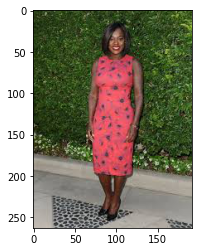

In [28]:
plt.imshow(image[0])

We generated batches of augmented images from the original image.The flow() function takes numpy data and generates batches of augmented data.

In [29]:
aug_iter = gen.flow(image)

Now we’ll get ten samples of the augmented images.

In [30]:
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

Now we’ll plot the augmented images.

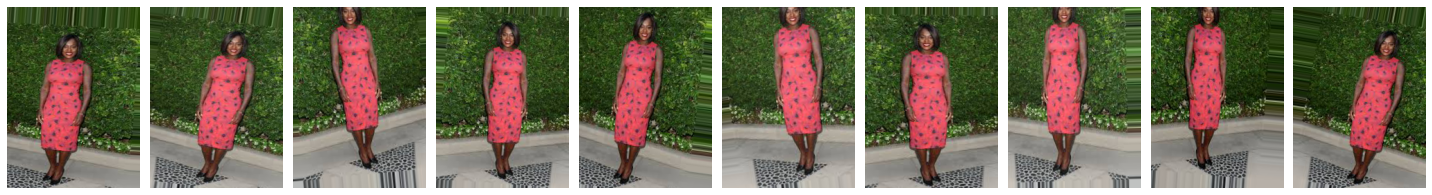

In [31]:
plotImages(aug_images)

### Create and Evaluate a Baseline Model

Since directly calling flow_from_directory method from ImageDataGenerator creates an error, we created instances of this class first. 

In [33]:
train_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()
test_gen=ImageDataGenerator()

In [34]:
train_generator =train_gen.flow_from_directory(
    directory='training_data',
    target_size=(148, 148),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=10,
    shuffle=True,
    seed=None
)

Found 100 images belonging to 2 classes.


In [35]:
valid_generator = val_gen.flow_from_directory(
    directory="validation_data",
    target_size=(148, 148),
    color_mode="rgb",
    batch_size=5,
    class_mode="categorical",
    shuffle=True
)

Found 30 images belonging to 2 classes.


In [36]:
test_generator = test_gen.flow_from_directory(
    directory="testing_data",
    target_size=(148, 148),
    color_mode="rgb",
    batch_size=5,
    class_mode=None,
    shuffle=False
)

Found 30 images belonging to 2 classes.


Adding data augmentation to the model

In [37]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Fitting the model

In [38]:
model.fit(x=train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    batch_size=1,
    epochs=10,
    verbose=2
)

Epoch 1/10
10/10 - 21s - loss: 0.9535 - accuracy: 0.7100 - val_loss: 0.7236 - val_accuracy: 0.5000
Epoch 2/10
10/10 - 23s - loss: 0.6827 - accuracy: 0.5500 - val_loss: 0.6851 - val_accuracy: 0.5333
Epoch 3/10
10/10 - 22s - loss: 0.6631 - accuracy: 0.7200 - val_loss: 0.6785 - val_accuracy: 0.5667
Epoch 4/10
10/10 - 22s - loss: 0.6567 - accuracy: 0.7000 - val_loss: 0.6757 - val_accuracy: 0.6667
Epoch 5/10
10/10 - 23s - loss: 0.6501 - accuracy: 0.7100 - val_loss: 0.6732 - val_accuracy: 0.5667
Epoch 6/10
10/10 - 19s - loss: 0.6360 - accuracy: 0.7700 - val_loss: 0.6711 - val_accuracy: 0.6667
Epoch 7/10
10/10 - 24s - loss: 0.6179 - accuracy: 0.8400 - val_loss: 0.6680 - val_accuracy: 0.7000
Epoch 8/10
10/10 - 34s - loss: 0.5934 - accuracy: 0.8400 - val_loss: 0.6672 - val_accuracy: 0.5667
Epoch 9/10
10/10 - 30s - loss: 0.5555 - accuracy: 0.8400 - val_loss: 0.6553 - val_accuracy: 0.7000
Epoch 10/10
10/10 - 29s - loss: 0.4979 - accuracy: 0.7700 - val_loss: 0.6242 - val_accuracy: 0.6333


### Tune the Model

In [52]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(148, 148, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(2, activation='softmax')
])

In [53]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [54]:
model.fit(x=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    batch_size=1,
    epochs=10,
    verbose=2
)

Epoch 1/10
10/10 - 35s - loss: 0.6897 - accuracy: 0.5200 - val_loss: 0.6876 - val_accuracy: 0.6000
Epoch 2/10
10/10 - 33s - loss: 0.6357 - accuracy: 0.6500 - val_loss: 0.7229 - val_accuracy: 0.4667
Epoch 3/10
10/10 - 33s - loss: 0.6280 - accuracy: 0.7200 - val_loss: 0.6922 - val_accuracy: 0.5333
Epoch 4/10
10/10 - 29s - loss: 0.5734 - accuracy: 0.7200 - val_loss: 0.7345 - val_accuracy: 0.5333
Epoch 5/10
10/10 - 32s - loss: 0.5599 - accuracy: 0.7600 - val_loss: 0.7224 - val_accuracy: 0.5000
Epoch 6/10
10/10 - 34s - loss: 0.5052 - accuracy: 0.7900 - val_loss: 0.8844 - val_accuracy: 0.5000
Epoch 7/10
10/10 - 32s - loss: 0.5152 - accuracy: 0.7700 - val_loss: 0.8150 - val_accuracy: 0.5000
Epoch 8/10
10/10 - 32s - loss: 0.4566 - accuracy: 0.7600 - val_loss: 0.8930 - val_accuracy: 0.5333
Epoch 9/10
10/10 - 29s - loss: 0.4773 - accuracy: 0.8300 - val_loss: 0.8807 - val_accuracy: 0.5000
Epoch 10/10
10/10 - 30s - loss: 0.4473 - accuracy: 0.7900 - val_loss: 0.9492 - val_accuracy: 0.5333


## Report Accuracy on Test Set

In [57]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()

In [ ]:
model.fit(x=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=test_generator,
    validation_steps=STEP_SIZE_TEST,
    batch_size=1,
    epochs=10,
    verbose=2
)